<a href="https://colab.research.google.com/github/shreeya-la/audio-ml/blob/main/yamnet(with_scores).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Download ESC50

In [ ]:
#!pip install tensorflow --upgrade

In [ ]:
# !pip uninstall tensorflow
# !pip uninstall tensorflow-io

In [ ]:
import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import librosa

In [ ]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

--2024-09-26 16:20:30--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2024-09-26 16:20:30--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2024-09-26 16:20:30--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <=>

In [ ]:
!unzip -qq master.zip

In [ ]:
%cd ESC-50-master
# create a dataframe
esc50_data = pd.read_csv('meta/esc50.csv')
esc50_data.head()

/content/ESC-50-master


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
animals = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow']
map_class_to_id = {'dog':0,'rooster':1, 'pig':2, 'cow':3, 'frog':4, 'cat':5, 'hen':6, 'insects':7, 'sheep':8, 'crow':9}

esc50_animals = esc50_data[esc50_data.category.isin(animals)]

class_id = esc50_animals['category'].apply(lambda name: map_class_to_id[name])
esc50_animals = esc50_animals.assign(target=class_id)

esc50_animals.head(10)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
29,1-121951-A-8.wav,1,8,sheep,False,121951,A
45,1-15689-A-4.wav,1,4,frog,False,15689,A
46,1-15689-B-4.wav,1,4,frog,False,15689,B
49,1-16568-A-3.wav,1,3,cow,False,16568,A
64,1-17585-A-7.wav,1,7,insects,False,17585,A
69,1-17970-A-4.wav,1,4,frog,False,17970,A
70,1-18074-A-6.wav,1,6,hen,False,18074,A


In [ ]:
def preprocess_wav(filename, target_sr=16000):
    filename = 'audio/' + filename
    # Load the .wav file using librosa
    audio, sampling_rate = librosa.load(filename, sr=None)

    # Resample to target sample rate (16kHz)
    audio = librosa.resample(audio, orig_sr=sampling_rate, target_sr=target_sr)

    # If audio has more than 1 channel, convert to mono
    if len(audio.shape) > 1:
        audio = librosa.to_mono(audio)

    # Convert to float32 TensorFlow tensor
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

    return audio_tensor

In [ ]:
# @tf.function
# def load_wav_16k_mono(filename):
#     """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
#     file_contents = tf.io.read_file(filename)
#     wav, sample_rate = tf.audio.decode_wav(
#           file_contents,
#           desired_channels=1)
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav

# YAMNet

In [ ]:
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

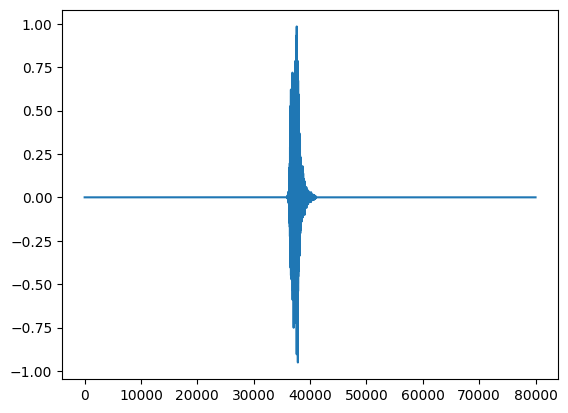

In [ ]:
# get a sample .wav file
sample_file = esc50_animals.iloc[0]['filename']
esc_single_waveform = preprocess_wav(sample_file)

# plot and display
_ = plt.plot(esc_single_waveform)
display.Audio(esc_single_waveform, rate=16000)

In [ ]:
class_map_path = yamnet.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

# for name in class_names[:10]:
#   print(name)
# print('...')

In [ ]:
# to find the top-scored class, take the maximum of the 521 aggregated scores.
scores, embeddings, spectrogram = yamnet(esc_single_waveform)
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Silence


In [ ]:
results = []

# for each file in the esc50_animals
for index, row in esc50_animals.iterrows():

    #preprocess
    filename = row['filename']
    wav = preprocess_wav(filename)

    #run yamnet
    scores, embeddings, spectrogram = yamnet(wav)

    # convert scores to numpy array and find the inferred class
    scores_np = scores.numpy()
    predicted = class_names[scores_np.mean(axis=0).argmax()]

    # Store the result
    results.append({
        #'filename': filename,
        'predicted class': predicted.lower(),
        'true class': row['category']
    })

results_df = pd.DataFrame(results)

In [ ]:
results_df.head(20)

,predicted class,true class
0,silence,dog
1,animal,crow
2,silence,dog
3,"livestock, farm animals, working animals",sheep
4,frog,frog
5,frog,frog
6,silence,cow
7,wild animals,insects
8,animal,frog
9,animal,hen


# Sequential Model

In [ ]:
class_map_path = yamnet.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [ ]:
animals = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}

esc50_animals = esc50_data[esc50_data.category.isin(animals)]

class_id = esc50_animals['category'].apply(lambda name: map_class_to_id[name])
esc50_animals = esc50_animals.assign(target=class_id)

esc50_animals.head(5)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
157,1-30226-A-0.wav,1,0,dog,True,30226,A
158,1-30344-A-0.wav,1,0,dog,True,30344,A
170,1-32318-A-0.wav,1,0,dog,True,32318,A


In [ ]:
# convert columns to numpy arrays
filenames = esc50_animals['filename']
targets = esc50_animals['target']
folds = esc50_animals['fold']

esc50 = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
esc50.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# def load_wav_for_map(filename, label, fold):
#     return preprocess_wav(filename), label, fold

# esc50 = esc50.map(load_wav_for_map)
# esc50.element_spec

In [ ]:
def load_wav_for_map(filename, label, fold):
    def _load_wav(filename):
        filename_str = filename.numpy().decode('utf-8')
        return preprocess_wav(filename)

    # wrap the python-based _load_wav function
    audio = tf.py_function(_load_wav, [filename], tf.float32)
    return audio, label, fold

esc50 = esc50.map(load_wav_for_map)
esc50.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  # run YAMNet to extract embedding from the wav data
  scores, embeddings, spectrogram = yamnet(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
esc50 = esc50.map(extract_embedding).unbatch()
esc50.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# clips from the same original source should always be in the same fold
cached_ds = esc50.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

In [ ]:
# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
num_classes = len(animals)

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes)
], name='my_model')

my_model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,826 (2.01 MB)

 Trainable params: 525,826 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Error in user-defined function passed to MapDataset:95 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::MemoryCacheImpl::ParallelMapV2::Filter::MemoryCacheImpl::Unbatch::Map::Map: TypeError: Invalid file: <tf.Tensor: shape=(), dtype=string, numpy=b'audio/1-100032-A-0.wav'>
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filea5nepfsv.py", line 19, in _load_wav
    retval__1 = ag__.converted_call(ag__.ld(preprocess_wav), (ag__.ld(filename),), None, fscope_1)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 460, in _call_unconverted
    return f(*args)

  File "<ipython-input-8-2c93a4188ba1>", line 4, in preprocess_wav
    audio, sampling_rate = librosa.load(filename, sr=None)

  File "/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py", line 176, in load
    y, sr_native = __soundfile_load(path, offset, duration, dtype)

  File "/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py", line 209, in __soundfile_load
    context = sf.SoundFile(path)

  File "/usr/local/lib/python3.10/dist-packages/soundfile.py", line 658, in __init__
    self._file = self._open(file, mode_int, closefd)

  File "/usr/local/lib/python3.10/dist-packages/soundfile.py", line 1212, in _open
    raise TypeError("Invalid file: {0!r}".format(self.name))

TypeError: Invalid file: <tf.Tensor: shape=(), dtype=string, numpy=b'audio/1-100032-A-0.wav'>


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_22248]